# A script for web scraping, generating JSON files and validating them.

### The easiest way to have the data is by just exporting by csv then reading it from the code, but more complex web scraping tools are used here.

In [74]:
import os
import json
import time

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from datetime import datetime
from bs4 import BeautifulSoup
from selenium import webdriver

from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [75]:
def validate_data(data):
    """
    Validates the structured JSON data.

    This function checks that all expected fields are present in the data and that the values
    are of the correct type.

    Args:
        data (dict): The structured JSON data as a dictionary.

    Returns:
        bool: True if the data is valid (all required fields are present and their values 
        have the correct type), False otherwise.

    The expected fields and their types are defined in the `expected_fields` dictionary. 
    If a field is missing in the data or the value of a field has the wrong type, 
    the function will print an error message and return False.
    """

    expected_fields = {
        "Name of Covered Entity": str,
        "State": str,
        "Covered Entity Type": str,
        "Individuals Affected": int,
        "Breach Submission Date": str,
        "Type of Breach": str,
        "Location of Breached Information": str,
        "Business Associate Present": str,
        "Web Description": str,
        "Date_Scraped": str,
        "Category": str
    }

    for field, expected_type in expected_fields.items():
        if field not in data:
            print(f"Missing field: {field}")
            return False
        if not isinstance(data[field], expected_type):
            print(f"Wrong data type for field {field}: expected {expected_type}, got {type(data[field])}")
            return False

    return True

In [76]:
def get_breach_reports():
    
    """
    This function scrapes data from the OCR Breach Portal and stores the structured data in 
    JSON files, one for each record. The data includes details about healthcare data breaches 
    such as the name of the entity, the state, the type of entity, the number of individuals 
    affected, the date of the breach submission, the type, and location of the breach, whether 
    a business associate was present, a web description, and the category of the breach.
    
    The function uses Selenium and BeautifulSoup for web scraping and relies on the website's structure as of the time of writing. It navigates through the pages of the breach report 
    table, scraping data from each row and storing it in a JSON file. It also includes a validation 
    step to ensure that the scraped data meets the expected structure.
    
    The data is stored in a directory named 'json_files', created if it doesn't exist.
    The naming convention of the files is based on the 'Name of Covered Entity' field, with special 
    characters replaced with underscores. Each JSON file includes a single record.
    
    The function will continue to scrape data and navigate to the next page as long as the pages are available. If an error occurs while trying to navigate to the next page, the function 
    assumes that there are no more pages and terminates the scraping process.
    """

    URL = "https://ocrportal.hhs.gov/ocr/breach/breach_report.jsf"
    driver = webdriver.Chrome(r'C:\Users\User\Desktop\chromedriver_win32/chromedriver.exe')
    driver.get(URL)
    
    # Create new directory
    if not os.path.exists('json_files'):
        os.makedirs('json_files')
        
    counter = 0
    no_more_pages = False
    
    while True:
        time.sleep(5)  # Wait for the page to load
        soup = BeautifulSoup(driver.page_source, "html.parser")
        breach_table = soup.find("table", attrs={"role": "grid", "style":"table-layout: auto;"}) 
        breach_rows = breach_table.find_all("tr")

        for row in tqdm(breach_rows[1:]): # Skip the header row
            data_ri = int(row.get('data-ri'))  # Get the current data-ri value

            # If the data-ri value matches the counter, process the row
            if data_ri == counter:
                cols = row.find_all("td")

            data = {
                "Name of Covered Entity": cols[1].text.strip(),
                "State": cols[2].text.strip(),
                "Covered Entity Type": cols[3].text.strip(),
                "Individuals Affected": int(cols[4].text.strip()),
                "Breach Submission Date": cols[5].text.strip(),
                "Type of Breach": cols[6].text.strip(),
                "Location of Breached Information": cols[7].text.strip(),
                "Business Associate Present": cols[8].text.strip(),
                "Web Description": cols[9].text.strip(),
                "Date_Scraped": str(datetime.now()),
                "Category": "OCR_Breaches_Archive" if datetime.strptime(cols[5].text.strip(), "%m/%d/%Y") < datetime.now() else "OCR_Breaches_Current"
            }
            
            is_valid = validate_data(data)
            if not is_valid:
                print(f"Data validation failed for record {counter}")
                continue
    
            filename = str(counter + 1) + ". "
            filename += cols[1].text.strip()\
                              .replace(" ", "_")\
                              .replace("/", "_")\
                              .replace("|", "_")\
                              .replace("/", "_")\
                              .replace(",", "_")\
                              .replace("*", "_")\
                              .replace(".", "_")\
                              .replace("?", "_")\
                              .replace("<", "_")\
                              .replace(">", "_")\
                              .replace("\"", "_")\
                              .replace("	", "_")
            filename += ".json"
            
            with open(f"json_files/{filename}", "w") as outfile: 
                json.dump(data, outfile)

            counter += 1

        # Go to next page after 100 records
        # If we didn't find a row with the next data-ri value, go to the next page
        if data_ri < counter:
            try:
                next_button = WebDriverWait(driver, 10).until(
                    EC.element_to_be_clickable((By.XPATH, "//a[contains(@class, 'ui-paginator-next') and not(contains(@class, 'ui-state-disabled'))]"))
                )
                driver.execute_script("arguments[0].click();", next_button)
                time.sleep(5)
            except Exception:
                no_more_pages = True
                break
        
        if no_more_pages:
            break 
        
    driver.quit()
    print("Scrapping is done!\nExiting the scrapping script!")

In [77]:
get_breach_reports()

C:\Users\User\AppData\Local\Temp\ipykernel_14832\1379780420.py:23: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(r'C:\Users\User\Desktop\chromedriver_win32/chromedriver.exe')
100%|██████████| 73/73 [00:00<00:00, 2214.57it/s]


Scrapping is done!
Exiting the scrapping script!


## Please wait for a minute after running the above code.

In [78]:
# initialize an empty list to store each data dict
data_list = []

# iterate over all json files in the directory
for file in tqdm(os.listdir('json_files')):
    if file.endswith('.json'):
        with open(os.path.join('json_files', file)) as f:
            data = json.load(f)
            data_list.append(data)

# convert the list of data dicts into a DataFrame
df = pd.DataFrame(data_list)
df

100%|██████████| 873/873 [00:02<00:00, 332.60it/s]


,Name of Covered Entity,State,Covered Entity Type,Individuals Affected,Breach Submission Date,Type of Breach,Location of Breached Information,Business Associate Present,Web Description,Date_Scraped,Category
0,PillPack LLC,NH,Healthcare Provider,19032,05/19/2023,Hacking/IT Incident,Network Server,No,,2023-05-28 15:55:49.093532,OCR_Breaches_Archive
1,Great Expressions Dental Centers,MI,Healthcare Provider,528,05/12/2023,Hacking/IT Incident,Network Server,No,,2023-05-28 15:55:49.097532,OCR_Breaches_Archive
2,Atlantic Dialysis Management Services - Spring...,NY,Business Associate,922,03/22/2023,Hacking/IT Incident,Network Server,Yes,,2023-05-28 15:55:49.135533,OCR_Breaches_Archive
3,Atlantic Dialysis Management Services - Ridgew...,NY,Business Associate,2204,03/22/2023,Hacking/IT Incident,Network Server,Yes,,2023-05-28 15:55:59.259996,OCR_Breaches_Archive
4,Atlantic Dialysis Management Services - 522012,NY,Business Associate,563,03/22/2023,Hacking/IT Incident,Network Server,Yes,,2023-05-28 15:55:59.260998,OCR_Breaches_Archive
...,...,...,...,...,...,...,...,...,...,...,...
868,Frideres Dental LLC,OR,Healthcare Provider,1596,03/24/2023,Hacking/IT Incident,Email,No,,2023-05-28 15:55:49.133533,OCR_Breaches_Archive
869,New Medical Healthcare,KS,Healthcare Provider,1557,03/22/2023,Unauthorized Access/Disclosure,Email,No,,2023-05-28 15:55:49.133533,OCR_Breaches_Archive
870,US Wellness Inc.,MD,Business Associate,15818,03/22/2023,Hacking/IT Incident,Network Server,Yes,,2023-05-28 15:55:49.134532,OCR_Breaches_Archive
871,Atlantic Dialysis Management Services - Mattoo...,NY,Business Associate,3851,03/22/2023,Hacking/IT Incident,Network Server,Yes,,2023-05-28 15:55:49.134532,OCR_Breaches_Archive


# A script containing data visualization code

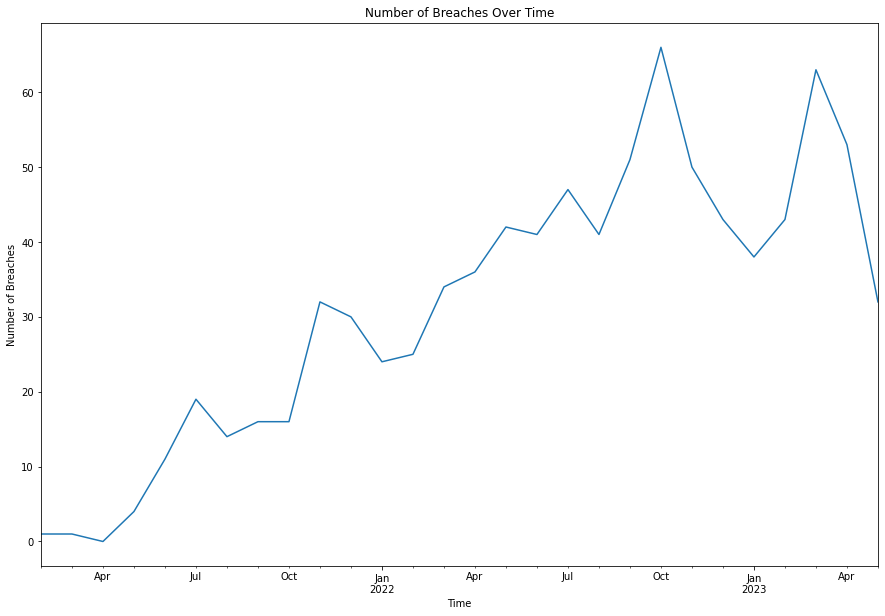

In [79]:
# convert the 'Breach Submission Date' column to datetime
df['Breach Submission Date'] = pd.to_datetime(df['Breach Submission Date'], format='%m/%d/%Y')

# Time series plot for number of breaches over time
plt.figure(figsize=(15,10))
df.set_index('Breach Submission Date').resample('M').size().plot()
plt.title('Number of Breaches Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Breaches')
plt.show()

## Here is a time series data vizualization that shows the number of breaches over time by taking a unit as a month. So it can be easily seen, when it increases, when decreases, and how drastically.

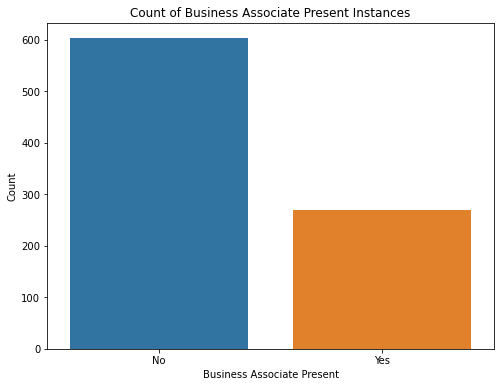

In [80]:
# Bar chart for count of 'Business Associate Present' instances
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='Business Associate Present')
plt.title('Count of Business Associate Present Instances')
plt.ylabel('Count')
plt.show()


## This visualization shows the proportion of those whose covered entity type is Business Associate to those, whose covered entity type is not Business Associate. Roughly, not business associates are twise more than business associates.

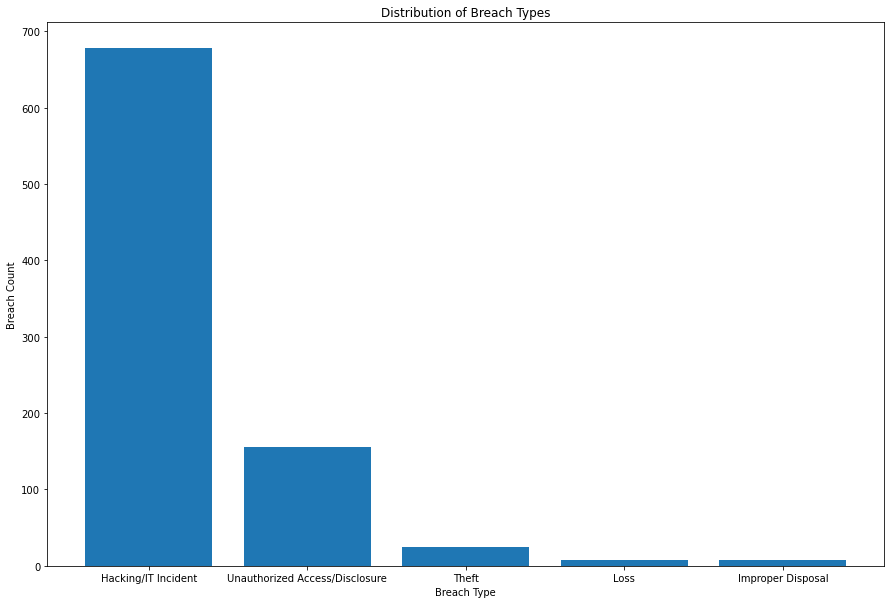

In [81]:
# Assuming you have breach data in a DataFrame called 'df' with a column 'BreachType'

# Count the occurrences of each breach type
breach_counts = df['Type of Breach'].value_counts()

# Create a bar chart
plt.figure(figsize=(15,10))
plt.bar(breach_counts.index, breach_counts.values)
plt.xlabel('Breach Type')
plt.ylabel('Breach Count')
plt.title('Distribution of Breach Types')
plt.show()

## The visualization above shows the numbers of breach counts based on the type of the breach. So that hacking/IT incident has significantly more breaches.

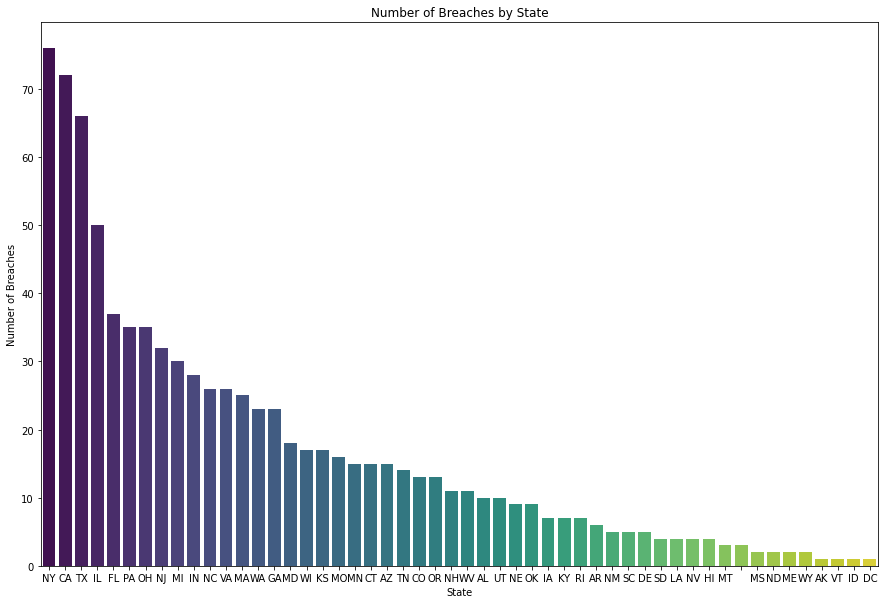

In [82]:
# Which states have the most reported breaches?
# Group by 'State' and count the number of breaches for each of them.
state_breaches = df.groupby('State')['Name of Covered Entity'].count().sort_values(ascending=False)

# Visualize
plt.figure(figsize=(15,10))
sns.barplot(x=state_breaches.index, y=state_breaches.values, palette="viridis")
plt.title('Number of Breaches by State')
plt.xlabel('State')
plt.ylabel('Number of Breaches')
plt.show()


## The visualization above shows the states and the corresponding number of breaches in descending order. As I need to answer for which state it has maximum value, I just need to look which sate is the first one, and that is NY.

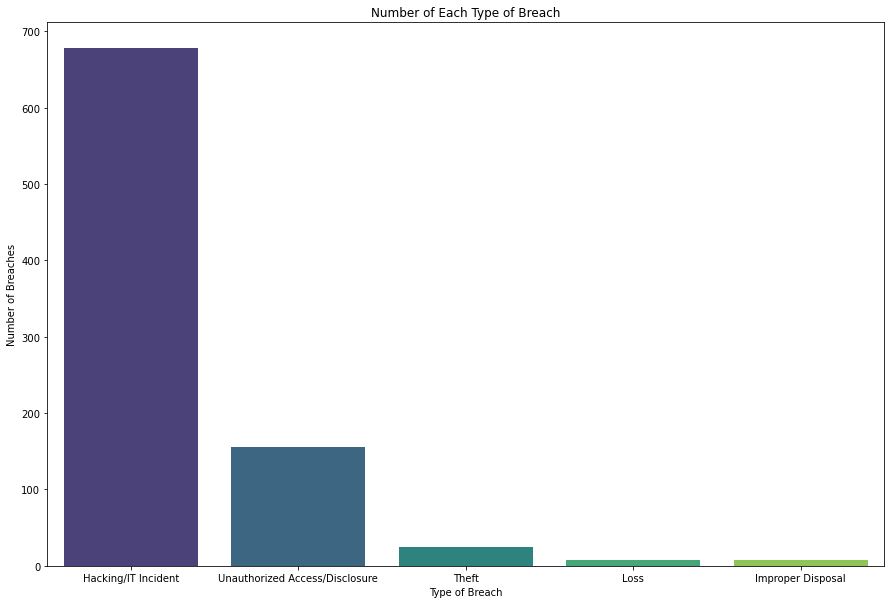

In [83]:
# What types of breaches are most common?
# Group by 'Type of Breach' and count the number of each type
breach_types = df['Type of Breach'].value_counts()

# Visualize
plt.figure(figsize=(15,10))
sns.barplot(x=breach_types.index, y=breach_types.values, palette="viridis")
plt.title('Number of Each Type of Breach')
plt.xlabel('Type of Breach')
plt.ylabel('Number of Breaches')
plt.show()

## Here we can see that for hacking/IT incident the number of breaches is the highest, so it is the most common one, as from 873 entities more than 650 are of that type. Second common one is unauthorized access/disclosure as it can be easily seen.

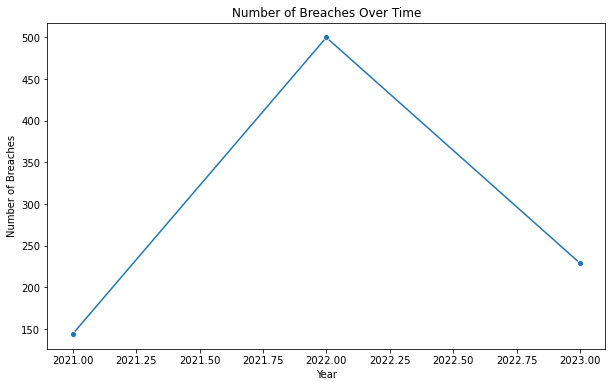

In [84]:
# How has the number of breaches changed over time?
# Convert 'Breach Submission Date' to datetime
df['Breach Submission Date'] = pd.to_datetime(df['Breach Submission Date'])

# Group by year and count the number of breaches for each
breaches_by_year = df.groupby(df['Breach Submission Date'].dt.year)['Name of Covered Entity'].count()

# Visualize
plt.figure(figsize=(10,6))
sns.lineplot(x=breaches_by_year.index, y=breaches_by_year.values, marker='o')
plt.title('Number of Breaches Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Breaches')
plt.show()


## The number of breaches has increased in 2021 and decreased in 2022. Moreover, it increased faster, than decreased.

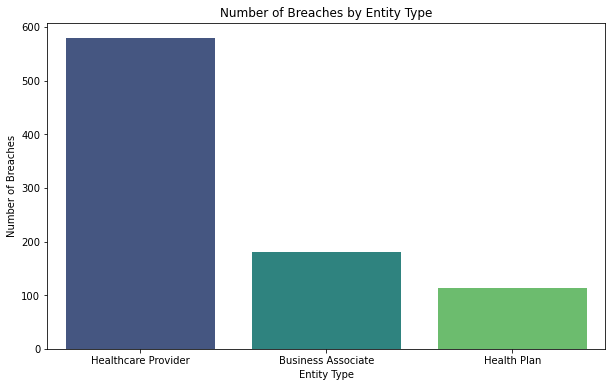

In [85]:
# What types of entities are most often involved in breaches?
# Group by 'Covered Entity Type' and count the number of breaches for each
entity_types = df['Covered Entity Type'].value_counts()

# Visualize
plt.figure(figsize=(10,6))
sns.barplot(x=entity_types.index, y=entity_types.values, palette="viridis")
plt.title('Number of Breaches by Entity Type')
plt.xlabel('Entity Type')
plt.ylabel('Number of Breaches')
plt.show()


## As it can be seen, the most common type is healthcare provider, than business associate entity type, than health plan.